# Model Failure Explanations for Regression

This notebook shows how to produce model failure explanations for regression problems with general SHAP values.

In this example, we construct a model to forecast GDP, then ask why it failed to predict the 2008-2009 financial crisis. We find that real estate loans as a percent of GDP is the most important variable.

This question is a specific example of a general question: Why did our model perform poorly on sample $x$?

In [1]:
import warnings
warnings.simplefilter('ignore')

import gshap
from gshap.datasets import load_gdp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.neighbors import KernelDensity

from datetime import datetime

We begin by loading the GDP dataset (compiled from FRED data). We will forecast GDP 1 year in advance, so we lag our $X$ variables by 1 timestep.

In [2]:
gdp = load_gdp()
X, y = gdp.data, gdp.target.iloc[1:]
X, date = X.drop('date', axis=1), pd.to_datetime(X['date']).iloc[1:]
X_lagged = X.shift(1).iloc[1:]

We will train our model on the years before the 2008 crash, and test on the years of the crash (2008-2009).

In [3]:
train_idx = date < datetime(2008, 1, 1)
test_idx = ~train_idx & (date <= datetime(2009, 1, 1))
X_train, X_test, y_train, y_test = (
    X_lagged[train_idx], X_lagged[test_idx],
    y[train_idx], y[test_idx]
)

Compute the sample weights using the inverse frequency of the outcome variable for the training and test datasets. Because our test dataset is small, this will not make much difference. I include it as a best practice.

In [4]:
def compute_sample_weight(y):
    kde = KernelDensity(bandwidth=.1, kernel='linear')
    y = y.values.reshape(y.shape[0], 1)
    kde.fit(y)
    return 1/np.exp(kde.score_samples(y))

sample_weight_train = compute_sample_weight(y_train)
sample_weight_test = compute_sample_weight(y_test)

Define a version of KNN regression which begins by running PCA on the input data.

In [5]:
from sklearn.neighbors import KNeighborsRegressor as KNeighborsRegressorMixin

class KNeighborsRegressor(KNeighborsRegressorMixin):
    def __init__(self, n_neighbors=4, n_components=5):
        super().__init__(n_neighbors)
        self.n_components = n_components
        
    def fit(self, X, y):
        self.pca = PCA(n_components=self.n_components)
        X = self.pca.fit_transform(X)
        return super().fit(X, y)
    
    def predict(self, X):
        X = self.pca.transform(X)
        return super().predict(X)

Now we can train our regressor. Although our model successfully predicts GDP growth until the financial crisis, it performs worse than chance from 2008-2009. Generally, despite good performance on the training dataset, our model performs poorly on our test sample $x$.

In [6]:
reg = KNeighborsRegressor().fit(X_train, y_train)
y_pred_train = reg.predict(X_train)
y_pred_test = reg.predict(X_test)
print('Train score: % .4f' % r2_score(y_train, y_pred_train, sample_weight_train))
print('Test score: % .4f' % r2_score(y_test, y_pred_test, sample_weight_test))

Train score:  0.4477
Test score: -3.1278


Here, we plot our model's GDP growth forecasts against true GDP growth. We see that our model tracks GDP growth prior to 2008, but not from 2008-2009.

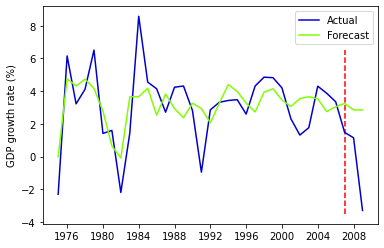

In [7]:
date_plt = date[date <= datetime(2009, 1, 1)]
y_plt = 100*np.concatenate((y_train, y_test))
y_pred_plt = 100*np.concatenate((y_pred_train, y_pred_test))
plt.plot(date_plt, y_plt, color='mediumblue')
plt.plot(date_plt, y_pred_plt, color='chartreuse')
plt.vlines(date_plt[y_train.shape[0]], -3.5, 6.5, color='r', linestyle='dashed')
plt.legend(('Actual', 'Forecast'))
plt.ylabel('GDP growth rate (%)')
plt.show()

Compute the G-SHAP values, where $g$ is weighted $R^2$ on our training data (pre-2008).

In [8]:
g = lambda y_pred: r2_score(y_train, y_pred, sample_weight=sample_weight_train)
explainer = gshap.KernelExplainer(reg.predict, X_train, g)
gshap_values_train = explainer.gshap_values(X_train, nsamples=1000)

For interpretation, we compare the training data to the background dataset in terms of $g$. We see that the predictions for the training data (pre-2008) have a higher $R^2$ than for the shuffled background data.

The sum of the G-SHAP values should approximately equal the difference in performance between the training data and the shuffled background data (allowing for samplign error).

In [9]:
g_comparison, g_background = explainer.compare(X_train, bootstrap_samples=1000)
print('R-squared for the training data: %.4f' % g_comparison)
print('R-squared for the shuffled background data: %.4f' % g_background)
print('Sum of G-SHAP values: %.4f' % gshap_values_train.sum())

R-squared for the training data: 0.4477
R-squared for the shuffled background data: -0.2030
Sum of G-SHAP values: 0.6475


To compare training and test performance, we repeat this exercise for our test data (2008-2009).

In [10]:
g = lambda y_pred: r2_score(y_test, y_pred, sample_weight=sample_weight_test)
explainer = gshap.KernelExplainer(reg.predict, X_train, g)
gshap_values_test = explainer.gshap_values(X_test, nsamples=1000)

In [11]:
g_comparison, g_background = explainer.compare(X_test, bootstrap_samples=1000)
print('R-squared for the test data: %.4f' % g_comparison)
print('R-squared for the shuffled background data: %.4f' % g_background)
print('Sum of the G-SHAP values: %.4f' % gshap_values_test.sum())

R-squared for the test data: -3.1278
R-squared for the shuffled background data: -3.9021
Sum of the G-SHAP values: 0.7455


Finally, we plot our results. This plot tells us the extent to which each variable contributes to model performance.

More precisely, our model has a performance score of $p_s$ for our sample $x$, and a performance score of $p_b$ for the shuffled background data. Each G-SHAP value $\phi_j$ is the difference in performance explained by feature $j$. A negative G-SHAP value indicates that feature $j$ degraded the model's performance.

Because the performance of the background dataset differs between our training and test $g$ functions, we normalize the G-SHAP values in order to compare training and test performance. We see that our model failed to predict the 2008 crisis due to real estate loans as a percent of GDP (RELoansPctGDP).

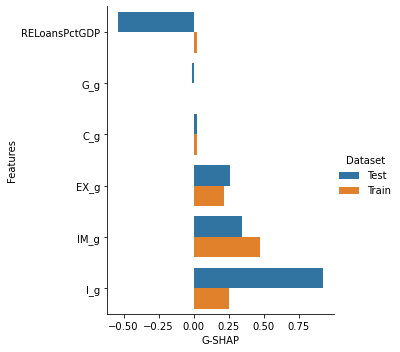

In [12]:
df = pd.DataFrame({
    'Features': X.columns,
    'Train': gshap_values_train/gshap_values_train.sum(),
    'Test': gshap_values_test/gshap_values_test.sum(),
})
df = df.sort_values('Test')
df = pd.melt(
    df, 
    id_vars='Features',
    value_vars=['Test', 'Train'],
    var_name='Dataset',
    value_name='G-SHAP',
)
sns.catplot(
    x='G-SHAP',
    y='Features',
    hue='Dataset',
    data=df,
    kind='bar',
    orient='h'
)
plt.show()